## Gawa Simulations

This jn is intended to create simulations of dwarf galaxies and globular clusters using as field stars the catalog of DES. These simulations will be later copied to gawa jn, a pipeline to detect stellar systems with field's stars. In principle this pipeline read a table in data base with g and r magnitudes, subtract the extinction in each band, and randomize the positions in RA and DEC in order to avoid stellar systems in the FoV. The star clusters are inserted later, centered in each HP pixel with specific nside.

To complete all the steps you just have to run all the cells below in sequence.

Firstly, install the packages not available in the image via terminal. Restart the kernel and so you can run the cell bellow.

In [1]:
# Refactor Imports
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import astropy.io.fits as fits
from gawa_simulations import (
    get_av,
    make_footprint,
    faker,
    join_cat,
    split_output_hpx,
    write_sim_clus_features,
)



Below are the items of the configuration for field stars and simulations. A small description follows as a comment.

In [2]:
# Main settings:
nside_ini = 64  # the nside in which pixel star clusters will be inserted in the center
nside_ftp = 4096  # nside of the footprint map
nside3 = 2 ** 18  # pixelization of the star's position
ra_min, ra_max = 45, 55  # 5., 85. # limits in ra of the simulated map
dec_min, dec_max = -30, -20  # -60., -20. # limits in dec of the simulated map
mmin, mmax, cmin, cmax = 17.00, 24.00, -0.4, 1.6  # magnitude and color limits of stars
ell_min, ell_max = 0.00, 0.20  # limits in ellipticity of star clusters simulated
pa_min, pa_max = 0., 180.  # limits in position angle
log10_mass_min, log10_mass_max = 3.00, 3.10  # limits for the visible mass of the clusters,

# avoiding simulate many stars unseen in the catalog given the limiting magnitude
mM_min, mM_max = 20.001, 20.002 # limits in modulus distance
log10_rexp_min, log10_rexp_max = 0.60, 1.00 # limits in exponential radius
survey = 'des' # survey name
frac_bin = 0.5 # fraction of binaries (amount of stars in binaries = Nbinaries / Ntotal)
IMF_author = 'Kroupa' # selection of initial mass function
border_extract = 1. # remove star clusters in the edge of the map, in degrees


In [3]:
# TODO: Identificar quando esses arquivos são utilizados e só abrir na hora de usar
file_iso = 'data/iso_input2.dat' # file with the isochrone
iso_info = np.loadtxt(file_iso, usecols=(1, 2), unpack=True) 
# just to print the metalicity and age of the input file:
FeH_iso = iso_info[0][0]
logAge_iso = iso_info[1][0]
# # hdu_ngp = fits.open("/archive/external_catalogs/SDSS3/schlegel/schlegel/SFD_dust_4096_ngp.fits", memmap=True)
# hdu_ngp = fits.open("sample_data/SFD_dust_4096_ngp.fits", memmap=True)
# ngp = hdu_ngp[0].data
# # hdu_sgp = fits.open("/archive/external_catalogs/SDSS3/schlegel/schlegel/SFD_dust_4096_sgp.fits", memmap=True)
# hdu_sgp = fits.open("sample_data/SFD_dust_4096_sgp.fits", memmap=True)
# sgp = hdu_sgp[0].data

Now, printing the age and metalicity of the model:

In [4]:
print('[M/H]={:.2f}, Age={:.2f} Gyr'.format(FeH_iso, 10**(logAge_iso-9)))

[M/H]=-2.00, Age=13.49 Gyr


In [5]:
hpx_ftp = make_footprint(ra_min, ra_max, dec_min, dec_max, nside_ftp)
print(len(hpx_ftp))

442147


Reading the catalog and writing as a fits file (to avoid read from the DB many times in the case the same catalog will be used multiple times).

In [6]:
# Lendo catalogo 'vac_ga_y6.catalog_6048'
# Usando um limit apenas para os testes executarem mais rápidos.
#  MAX_ROWS = None para ler o arquivo inteiro.
MAX_ROWS = 500
with open("sample_data/catalog_6048.csv") as fp:
    # 'ra', 'dec', 'mag_g', 'magerr_g', 'mag_r', 'magerr_r'
    RA, DEC, MAG_G, MAGERR_G, MAG_R, MAGERR_R = np.genfromtxt(
        fp, dtype=float, delimiter=";", names=True, unpack=True, 
        max_rows=MAX_ROWS  
    )
print(len(RA))


500


The cells below reads the position, calculates the extinction using the previous function and <br>
correct the aparent magnitude (top of the Galaxy), filter the stars for magnitude and color ranges, <br> 
and writes a file with the original position of the stars and corrected magnitudes.

In [7]:
# Le o arquivo NGP
hdu_ngp = fits.open("sample_data/SFD_dust_4096_ngp.fits", memmap=True)
ngp = hdu_ngp[0].data

# Le o arquivo SGP
hdu_sgp = fits.open("sample_data/SFD_dust_4096_sgp.fits", memmap=True)
sgp = hdu_sgp[0].data


c = SkyCoord(
    ra = RA * u.degree, 
    dec = DEC * u.degree, 
    frame='icrs'
)
L = c.galactic.l.degree
B = c.galactic.b.degree


MAG_G -= 1.19863 * get_av(L, B, ngp, sgp)
MAG_R -= 0.83734* get_av(L, B, ngp, sgp)

cond = (MAG_G < mmax)&(MAG_G > mmin)&(MAG_G-MAG_R > cmin)&(MAG_G-MAG_R < cmax)

RA = RA[cond]
DEC = DEC[cond]
MAG_G = MAG_G[cond]
MAG_R = MAG_R[cond]
MAGERR_G = MAGERR_G[cond]
MAGERR_R = MAGERR_R[cond]

col1 = fits.Column(name='RA', format='D', array=RA)
col2 = fits.Column(name='DEC', format='D', array=DEC)
col3 = fits.Column(name='MAG_G', format='E', array=MAG_G)
col4 = fits.Column(name='MAG_R', format='E', array=MAG_R)
col5 = fits.Column(name='MAGERR_G', format='E', array=MAGERR_G)
col6 = fits.Column(name='MAGERR_R', format='E', array=MAGERR_R)

cols = fits.ColDefs([col1, col2, col3, col4, col5, col6])
tbhdu = fits.BinTableHDU.from_columns(cols)

# Escreve o arquivo no diretório results
# TODO: Talves o arquivo fits pudesse ser escrito já compactato. fits.fz
tbhdu.writeto('results/DES_Y6_Gold_v1.fits', overwrite=True)
# '''
# hdu = fits.open("DES_Y6_Gold_v1.fits", memmap=True)
# RA = hdu[1].data.field('RA')
# DEC = hdu[1].data.field('DEC')
# MAG_G = hdu[1].data.field('MAG_G')
# MAG_R = hdu[1].data.field('MAG_R')
# MAGERR_G = hdu[1].data.field('MAGERR_G')
# MAGERR_R = hdu[1].data.field('MAGERR_R')
# '''

## Simulation of dwarf galaxies and globular clusters

In fact, the dwarf galaxies and globular clusters are very similar in terms of stellar populations. Dwarf galaxies
have a half-light radius larger than globular clusters (given the amount of dark matter) with the same absolute magnitude. The code below simulates stars using a Kroupa or Salpeter IMF, and an exponential radius for the 2D distribution of stars. 

Calculating the properties of the sample of simulated clusters. Write the properties to file 'objects.dat'.

In [8]:
# TODO: A geração do arquivo objects.dat me parece que pode ser uma função.

cell_area = hp.nside2pixarea(nside_ini, degrees=True)

area = (
    (dec_max - dec_min)
    * np.cos(np.deg2rad((ra_max + ra_min) / 2.0))
    * (ra_max - ra_min)
)

vertices = hp.ang2vec(
    [
        ra_min + border_extract,
        ra_max - border_extract,
        ra_max - border_extract,
        ra_min + border_extract,
    ],
    [
        dec_min + border_extract,
        dec_min + border_extract,
        dec_max - border_extract,
        dec_max - border_extract,
    ],
    lonlat=True,
)

hp_sample_un = hp.query_polygon(nside_ini, vertices, inclusive=False, nest=True, buff=None)


RA_pix, DEC_pix = hp.pix2ang(nside_ini, hp_sample_un, nest=True, lonlat=True)

c = SkyCoord(ra=RA_pix * u.degree, dec=DEC_pix * u.degree, frame='icrs')
L = c.galactic.l.degree
B = c.galactic.b.degree

# TODO: Se possivel utilizar o formato csv, 
# com a primeira linha sendo os nomes das colunas 
# e um separador melhor que espaço tipo ; ou |
# Pode ser criado usando o proprio Numpy. 
# np.savetxt(path, X, delimiter=';', header= ';'.join(X.dtype.names))
with open('results/objects.dat', 'w') as obj_file:

    # TODO: Seria interessante ter uma descrição do que está
    #  sendo feito para gerar esse arquivo.
    mM = mM_min + np.random.rand(len(hp_sample_un)) * (mM_max - mM_min)
    r_exp = 10**(log10_rexp_min * (log10_rexp_max / log10_rexp_min) ** np.random.rand(len(hp_sample_un)))
    mass = 10**(log10_mass_min * (log10_mass_max / log10_mass_min) ** np.random.rand(len(hp_sample_un)))
    dist = 10 ** ((mM/5) + 1)

    ell = ell_min + np.random.rand(len(hp_sample_un)) * (ell_max - ell_min)
    pa = pa_min + np.random.rand(len(hp_sample_un)) * (pa_max - pa_min)

    for i in range(len(hp_sample_un)):
        print('{:d} {:.4f} {:.4f} {:.4f} {:.4f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}'.format(
            hp_sample_un[i], L[i], B[i], RA_pix[i], DEC_pix[i], r_exp[i], ell[i], pa[i], \
            mass[i], dist[i]), file=obj_file)




## Dist stars
Reading data from magnitude and errors.



In [9]:
# TODO: Pode virar uma função na biblioteca. 
mag1_, err1_, err2_ = np.loadtxt('data/errors_Y6.dat', usecols=(0, 1, 2), unpack=True)
err1_ += 0.015; err2_ += 0.015

Now simulating the clusters using 'faker' function.

In [10]:
# Workflow Parsl
import parsl
from parsl.app.app import python_app, bash_app
from parsl.configs.local_threads import config

# Progress Bar with tqdm
import sys
from time import sleep
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm

# Remove as configurações do Parsl caso já tenham sido carregadas antes.
parsl.clear()
# Carrega as configurações e reserva os recursos.
parsl.load(config)

@python_app
def faker_app(N_stars_cmd, frac_bin, IMF_author, x0, y0, rexp, ell_, pa, dist, hpx):

    faker(
        N_stars_cmd,
        frac_bin,
        IMF_author,
        x0,
        y0,
        rexp,
        ell_,
        pa,
        dist,
        hpx,
        cmin,
        cmax,
        mmin,
        mmax,
        mag1_,
        err1_,
        err2_,
        file_iso,
    )


futures = list()

# Cria uma Progressbar (Opcional)
with tqdm(total=len(hp_sample_un), file=sys.stdout) as pbar:
    pbar.set_description("Submit Parsls Tasks")

    # Submissão dos Jobs Parsl
    for i in range(len(hp_sample_un)):
        # TODO: Descrever essa operação, esse valor 0.54 é um parametro? é fixo para sempre?
        # Deveria estar na lista de variaveis no inicio do JN?
        N_stars_cmd = int(mass[i] / 0.54)
        # os.register_at_fork(after_in_child=lambda: _get_font.cache_clear())
        futures.append(
            faker_app(
                N_stars_cmd,
                frac_bin,
                "Kroupa",
                RA_pix[i],
                DEC_pix[i],
                r_exp[i],
                ell[i],
                pa[i],
                dist[i],
                hp_sample_un[i],
            )
        )

        pbar.update()
# Fim da submissão dos Jobs,


# Espera todas as tasks Parsl terminarem
# Este loop fica monitarando as parsl.futures
# Até que todas tenham status done.
# Esse bloco todo é opicional

# Progressbar para acompanhar as parsl.tasks.
print("Tasks Done:")
with tqdm(total=len(futures), file=sys.stdout) as pbar2:
    # is_done é um array contendo True ou False para cada task
    # is_done.count(True) retorna a quantidade de tasks que já terminaram.
    is_done = list()
    done_count = 0
    while is_done.count(True) != len(futures):
        is_done = list()
        for f in futures:
            is_done.append(f.done())

        # Só atualiza a pbar se o valor for diferente.
        if is_done.count(True) != done_count:
            # Reset é necessário por que a quantidade de iterações
            # é maior que a quantidade de jobs.
            pbar2.reset(total=len(futures))

            done_count = is_done.count(True)
            pbar2.update(done_count)

        if done_count < len(futures):
            sleep(3)


Submit Parsls Tasks: 100%|██████████| 66/66 [00:01<00:00, 53.29it/s]
Tasks Done:
100%|██████████| 66/66 [00:00<00:00, 42295.50it/s]


Now functions to join catalogs of simulated clusters and field stars, and to estimate signal-to-noise ratio.

In [11]:
# def JoinCat():

# def SNR_estimate(RA__, DEC__, G__, GR__, PIX_sim, nside1, mM_, inner_circle, rin_annulus, rout_annulus):

# def WriteSimClusFeatures():
    
# def SplitOutputHPX(file_in, out_dir):

# def SplitFtpHPX(file_in, out_dir, nside_in=4096, nest_in=True, nside_out=64, nest_out=True):


Now applying the two functions.

In [12]:
# TODO: Gerar todos os arquivos de resultados no mesmo diretório ('results').
mockcat = join_cat(
    ra_min,
    ra_max,
    dec_min,
    dec_max,
    hp_sample_un,
    survey,
    RA,
    DEC,
    MAG_G,
    MAG_R,
    MAGERR_G,
    MAGERR_R,
    nside_ini,
    mmax,
    mmin,
    cmin,
    cmax)
# TODO: Exemplo para ler as primeiras linhas deste arquivo para verificar os resultados.
print(mockcat)

results/des_mockcat_for_detection.fits


In [13]:
split_output_hpx(mockcat, 'results/HPX_cats')
# SplitFtpHPX('ftp_4096_nest.fits', 'HPX_ftp')

In [14]:
clus_feat = write_sim_clus_features(mockcat, hp_sample_un, nside_ini, mM)
print(clus_feat)

/home/glauber/linea/gawa_simulations/gawa_simulations/gawa.py:712: RuntimeWarning: divide by zero encountered in double_scalars
  return len(r_star[r_star < inner_circle]) / np.sqrt(N_bg_equal_area)


results/N_stars.dat


Merge both files in a single file using join command.

In [2]:
import os
from pathlib import Path
# TODO: Transformar em uma função
os.system('join --nocheck-order results/N_stars.dat results/objects.dat > results/star_clusters_simulated.dat')

star_clusters_simulated = Path("results", "star_clusters_simulated.dat")

A few plots to characterize the simulated clusters.

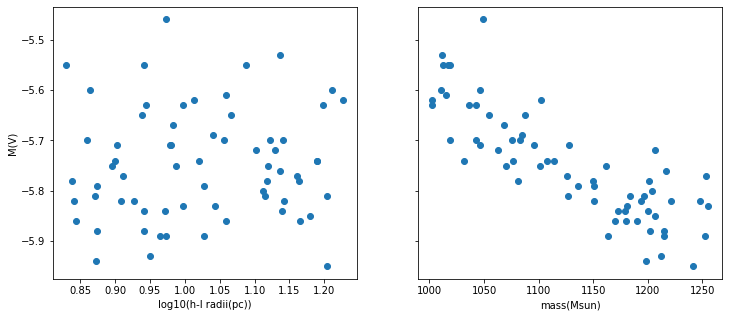

In [3]:
# TODO: Renomear essa função!
from gawa_simulations.plot import unnamed_plot
unnamed_plot(star_clusters_simulated)


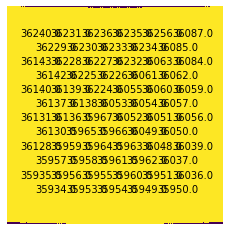

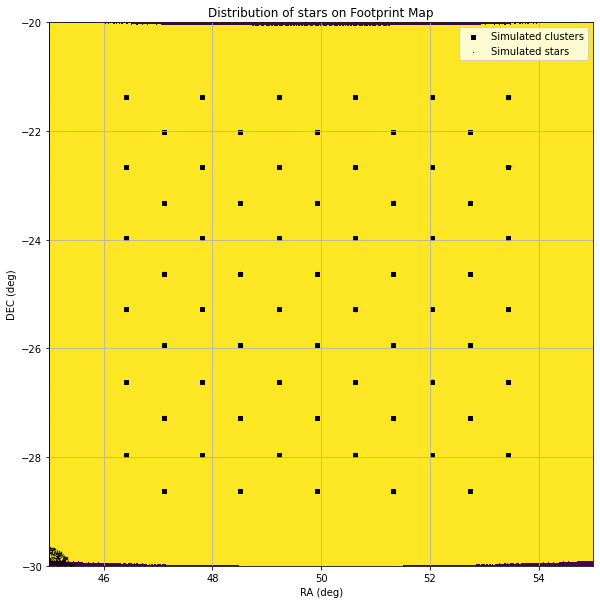

66


In [2]:
# Plot footprint map to check area.
from pathlib import Path
from gawa_simulations.plot import plot_ftp

ftp_fits = Path("data", "ftp_4096_nest.fits")

# TODO: Estes parametros não são necessários se o JN for executado todo
star_clusters_simulated = Path("results", "star_clusters_simulated.dat")
mockcat = Path("results", "des_mockcat_for_detection.fits")
ra_min, ra_max = 45, 55  # 5., 85. # limits in ra of the simulated map
dec_min, dec_max = -30, -20  # -60., -20. # limits in dec of the simulated map

plot_ftp(ftp_fits, star_clusters_simulated, mockcat, ra_max, ra_min, dec_min, dec_max)


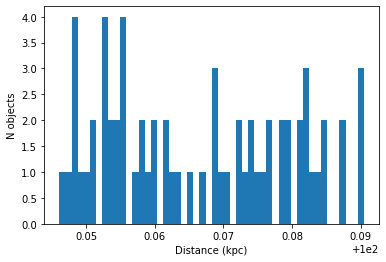

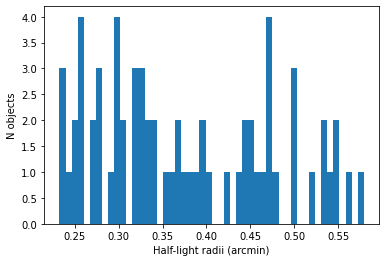

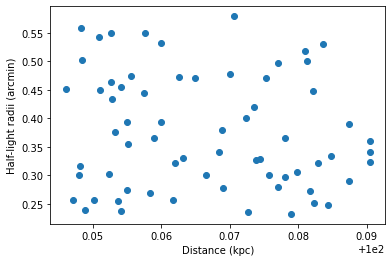

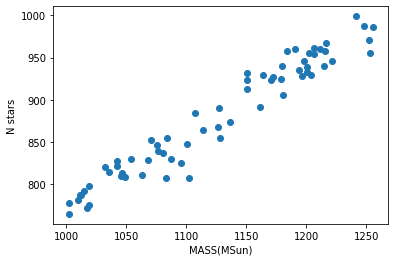

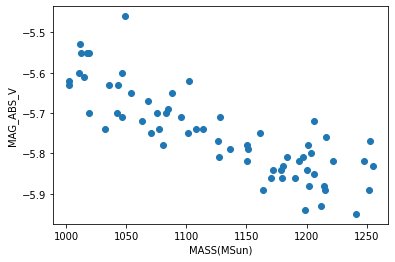

In [1]:
# Plots to analyze the simulated clusters.
from pathlib import Path
from gawa_simulations.plot import plots_ang_size

ftp_fits = Path("data", "ftp_4096_nest.fits")

# TODO: Estes parametros não são necessários se o JN for executado todo
star_clusters_simulated = Path("results", "star_clusters_simulated.dat")
mmin, mmax, cmin, cmax = 17.00, 24.00, -0.4, 1.6  # magnitude and color limits of stars
# Diretório onde estão os arquivo _clus.dat
clus_path = Path("results")
output_plots = Path("results/plots")
plots_ang_size(star_clusters_simulated, clus_path, mmin, mmax, cmin, cmax, output_plots)

# TODO: Seria interessante dividir essa função em duas
# Uma para os plots de _clus.dat
# Outra para os 4 plots do final.
# Dessa forma a geração dos plots _clus.dat poderia ser paralelizada.


In [ ]:
# TODO: Continuar DAQUI!
# def plots_ref():
# plots_ref()

Copying the main files to the folder where the Gawa code will be able to detect the simulated clusters.

In [ ]:
# os.system('cp ftp_4096_nest.fits ../ga-wazpy_detect_sim/raw_ftp/')
# os.system('cp des*_detection.fits ../ga-wazpy_detect_sim/raw_cats_corr/')
# os.system('cp star_clusters_simulated.dat ../ga-wazpy_detect_sim/')
# os.system('cp _*.png ../ga-wazpy_detect_sim/')
# os.system('cp *_cmd.png ../ga-wazpy_detect_sim/')
# os.system('ls *_cmd.png > list_cmds.dat')
# os.system('python format_html.py > sim_main.html')
# os.system('cp sim_main.html ../ga-wazpy_detect_sim/')

In [ ]:
# def plot_err():
# plot_err()

In [ ]:
# def RemoveCloseStars(name_cat, output_cat, PSF_factor):

# RemoveCloseStars('des_mockcat_for_detection.fits', 'des_mockcat_for_detection_wo_closest.fits', 1.0)